## Introduction to Neural Networks - Fraud Detection

**Context**

Nielsen reports that U.S. card fraud (credit, debt, etc) was reportedly 9 billion dollars in 2016 and expected to increase to 12 billion dollars by 2020. For perspective, in 2017 both PayPal's and Mastercard's revenue was only $10.8 billion each.
Therefore, it is important that credit card companies should be able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.


**Objective:**

Suppose you are working as a Data scientist in a Credit Card company named **"CCFraud"** and  given the credit card transactions, you  need to  build a Model  (i.e. Multilayer perceptrons) for Fraud Detection using Keras.

This notebook covers,

1. Creating a Model

2. Adding Layers

3. Activations

4. Optimizers and Loss functions

5. Earlystopping

6. Weight Initalization

7. Dropout

8. Model Evaluation

### Dataset Description

The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data is not provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

**Time** contains the seconds elapsed between each transaction and the first transaction in the dataset.


**Amount** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.


**Class** is the response variable and it takes value 1 in case of fraud and 0 otherwise.



In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import all necessary libraries

In [ ]:
#importing tensorflow
import tensorflow as tf
print(tf.__version__)

2.11.0


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
import seaborn as sns
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam


##Importing data

In [2]:
#reading dataset
data = pd.read_csv('data/creditcard.csv')

##Overview of Dataset

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


###Let's check the missing values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

* This shows that there are 284807 instances and 31 attributes including the class attribute.
*  As you can see there are no null values in any of the column

In [5]:
#Number of distinct categories or classes i.e., Fraudulent and Genuine
data['Class'].nunique()

2

* As expected, there are only 2 classes.

In [6]:

#checking the percentage of each class in the dataset
(data.Class.value_counts())/(data.Class.count())

0    0.998273
1    0.001727
Name: Class, dtype: float64

* This shows a complete imbalance of classes. There are 99.82% 'Genuine' (0) instances and only 0.17% 'Fraudulent' (1) instances. This means that we are aiming to predict anomalous events.

In [7]:
print("*********Losses due to fraud:************\n")
print("Total amount lost to fraud")
print(data.Amount[data.Class == 1].sum())
print("Mean amount per fraudulent transaction")
print(data.Amount[data.Class == 1].mean())
print("Compare to normal transactions:")
print("Total amount from normal transactions")
print(data.Amount[data.Class == 0].sum())
print("Mean amount per normal transactions")
print(data.Amount[data.Class == 0].mean())

*********Losses due to fraud:************

Total amount lost to fraud
60127.97
Mean amount per fraudulent transaction
122.21132113821139
Compare to normal transactions:
Total amount from normal transactions
25102462.04
Mean amount per normal transactions
88.29102242231328


##Let's Explore the data

<Axes: >

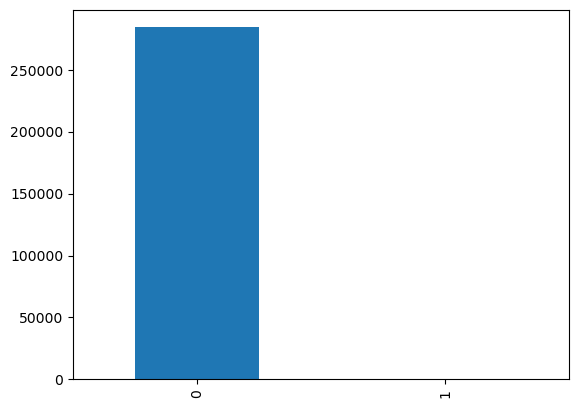

In [8]:
#visual representation of instances per class
data.Class.value_counts().plot.bar()

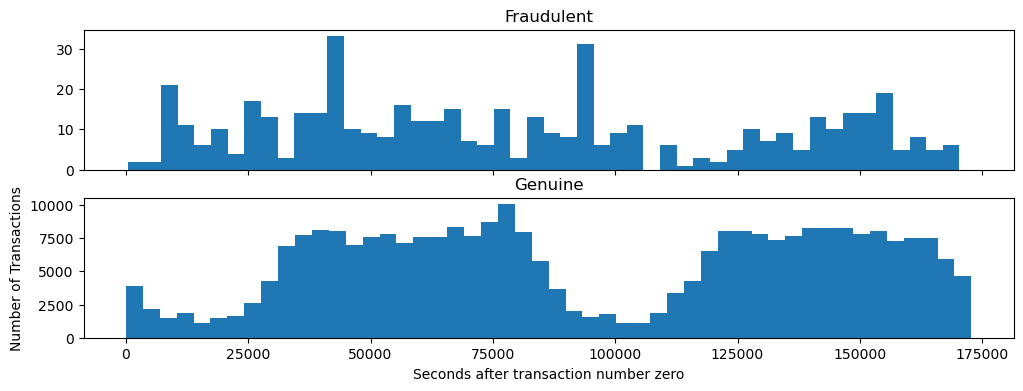

In [9]:
#Histrogram for feature Time
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

ax1.hist(data["Time"][data["Class"] == 1], bins = 50)
ax1.set_title('Fraudulent')

ax2.hist(data["Time"][data["Class"] == 0], bins = 50)
ax2.set_title('Genuine')

plt.xlabel('Seconds after transaction number zero')
plt.ylabel('Number of Transactions')
plt.show()

* The transactions occur in a cyclic way. But the time feature does not provide any useful information as the time when the first transaction was initiated is not given. Thus, we'll drop this feature.

In [10]:
#Dropping time feature
data = data.drop("Time", axis = 1)

###Let's take a look at the V1,...,V28 features.

In [11]:

Vfeatures = data.iloc[:,1:29].columns
print(Vfeatures)

Index(['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


In [12]:
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Checking correlation between features and the likelihood of the transaction to be fraud on the unbalanced dataset

Text(0.5, 1.0, 'Imbalanced Correlation Matrix')

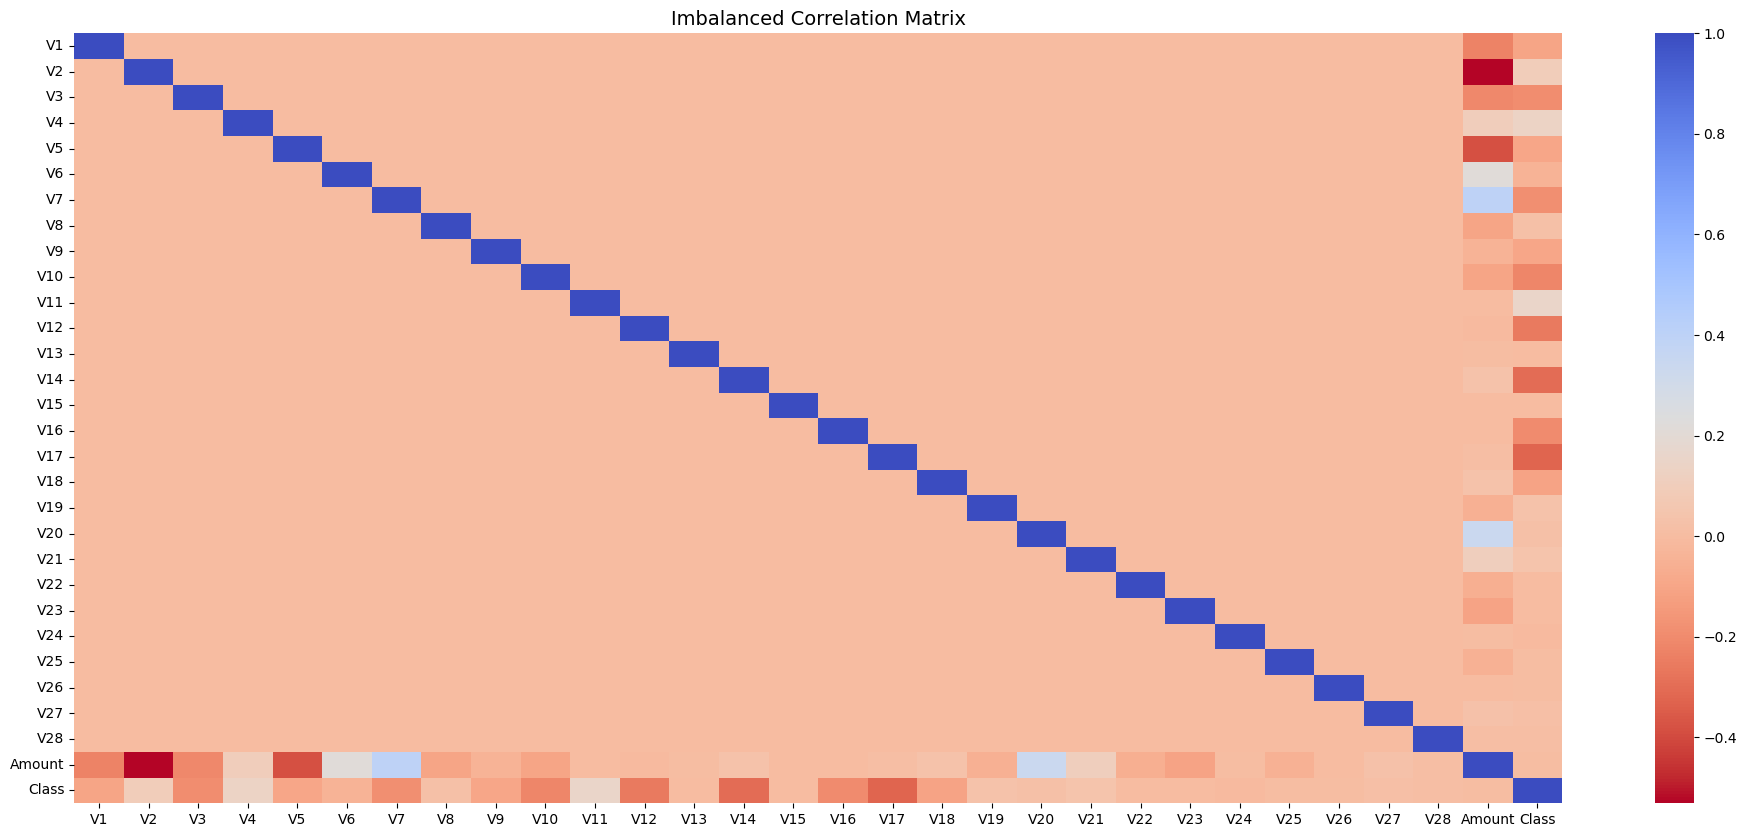

In [13]:

f, ax1 = plt.subplots(figsize=(24,10))

corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)

As seen, the correlations cannot be properly visualized because of the imbalance in the dataset. This is because the correlation matrix is affected by the high imbalance betwen the classes. But we can still analyse that there is high negative correlation between principle component ( v2 and v5 ) and Amount

###Separating response variable and predictors

In [14]:
X_data = data.iloc[:,0:29]
y_data = data.iloc[:, -1]

In [15]:
#printing the shape of the data
print(y_data.shape)
print(X_data.shape)


(284807,)
(284807, 29)


In [16]:
X_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


###Data Pre-processing

In [17]:
#Standardizing the Amount column (All other 'V' columns are already scaled as they've undergone PCA transformation).
from sklearn.preprocessing import StandardScaler
X_data['normalizedAmount'] = StandardScaler().fit_transform(X_data['Amount'].values.reshape(-1,1))  # Normalize 'Amount' in [-1,+1] range
X_data= X_data.drop(['Amount'],axis=1)

In [19]:
X_data.shape

(284807, 29)

###Splitting the Data into train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

In [ ]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227845, 29)
(56962, 29)
(227845,)
(56962,)


##Model Building

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)

In [ ]:
# Pandas Series.ravel() function returns the flattened underlying data as an ndarray.
random_forest.fit(X_train,y_train.values.ravel())    # np.ravel() Return a contiguous flattened array

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = random_forest.predict(X_test)

In [ ]:
random_forest.score(X_test,y_test)

0.9995611109160493

In [ ]:

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

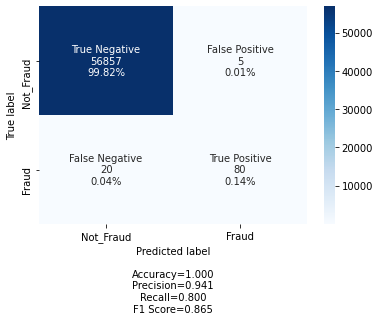

In [ ]:



cm1=confusion_matrix(y_test, y_pred)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm1, q 
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

## Model evaluation criterion

### Model can make wrong predictions as:
* Predicting a transaction is fraud  and the transaction  is not fraud
* Predicting a transaction  is not fraud and  transaction is  fraud

### Which case is more important?
* Predicting that transaction is not fraud but it is Fraud. It might enable lot of criminal activities and heavy loss to the bank

### How to reduce this loss i.e need to reduce False Negative?
* Company  would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false Negative. Hence, the focus should be on increasing Recall or minimizing the false Negative or in other words identifying the True Positive(i.e. Class 1) so that the Company can identify the fraud transaction.

**Conclusion:**

- while only 5 regular transactions are wrongly predicted as fraudulent, the model only detects 81% of the fraudulent transactions. As a consequence 19 fraudulent transactions are not detected (False Negatives).

- Let's see if we can improve this performance with other machine learning / deep learning models in the rest of the notebook.

## Let's now explore Neural Network models

## Deep neural network

Model-1

- We will use a simple NN made of 5 fully-connected layers with ReLu activation. The NN takes a vector of length 29 as input. This represents the information related to each transactions, ie each line with 29 columns from the dataset. For each transaction, the final layer will output a probability distribution (sigmoid activation function) and classify either as not fraudulent (0) or fraudulent (1).
- a dropout step is included to prevent overfitting.



**Dropout**

Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly.

### Creating a model

Keras model object can be created with Sequential class

At the outset, the model is empty per se. It is completed by adding additional layers and compilation


In [ ]:
#initialize the model
model = Sequential()

### Adding layers [layers and activations]

Keras layers can be added to the model

Adding layers are like stacking lego blocks one by one

It should be noted that as this is a classification problem, sigmoid layer (softmax for multi-class problems) should be added


In [ ]:

# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model.add(Dense(units=16, input_dim = 29,activation='relu'))   # input of 29 columns as shown above
# hidden layer
model.add(Dense(units=24,activation='relu'))
#Adding Dropout to prevent overfitting
model.add(Dropout(0.5))
model.add(Dense(24,activation='relu'))
model.add(Dense(24,activation='relu'))
# Adding the output layer
# Notice that we do not need to specify input dim.
# we have an output of 1 node, which is the the desired dimensions of our output (fraud or not)
# We use the sigmoid because we want probability outcomes
model.add(Dense(1,activation='sigmoid'))                        # binary classification fraudulent or not

### Model compile [optimizers and loss functions]

Keras model should be "compiled" prior to training

Types of loss (function) and optimizer should be designated


In [ ]:
# Create optimizer with default learning rate
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

###Let's print the summary of the model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 2,113
Trainable params: 2,113
Non-trainable params: 0
______________________________________________________

## Training [Forward pass and Backpropagation]

Training the model

In [ ]:

#fitting the model
history=model.fit(X_train,y_train,batch_size=15,epochs=10,validation_split=0.2)

Epoch 1/10
12152/12152 [==============================] - 49s 3ms/step - loss: 0.0278 - accuracy: 0.9934 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 2/10
12152/12152 [==============================] - 34s 3ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.0023 - val_accuracy: 0.9994
Epoch 3/10
12152/12152 [==============================] - 35s 3ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 4/10
12152/12152 [==============================] - 34s 3ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0026 - val_accuracy: 0.9995
Epoch 5/10
12152/12152 [==============================] - 35s 3ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 6/10
12152/12152 [==============================] - 35s 3ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 7/10
12152/12152 [==============================] - 35s 3ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0

Plotting the train and test loss

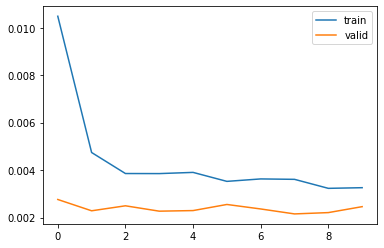

In [ ]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


### Evaluation
Keras model can be evaluated with evaluate() function

Evaluation results are contained in a list



1781/1781 [==============================] - 3s 2ms/step - loss: 0.0040 - accuracy: 0.9994


- The model achieves an accuracy of 99.95% ! Is this a good performance ?
- Remember that our dataset is significantly composed of non fraudulent samples with only 172 fraudulent transactions per 100,000. Consequently, a model predicting every transaction as 'non fraudulent' would achieve 99.83% accuracy despite being unable to detect a single fraudulent case !

In [ ]:
print(score)


[0.003956223838031292, 0.9994382262229919]


Let's Print confusion matrix

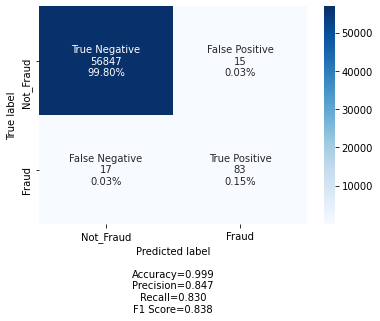

In [ ]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred1 = model.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm2,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

Detection of fraudulent transactions did not improve compared to the previous machine learning model ( Randomforest).

- There are 100 fraudulent transactions in the test data and  yet 15 fraudulent transactions are not identified (false negative) which remains an issue. Our objective must be to detect as many fraudulent transactions as possible since these can have a huge negative impact.

- 15 regular transactions are detected as potentially fraudulent by the model. These are false positive. This number is negligible.

**Conclusion:**

We must find ways to further reduce the number of false negative.

#Model-2

##Let's try another architecture to get the better Recall


There are some basic Hyperparameters which can help to get the better model performance.

**Early stopping:**

During training, the model is evaluated on a holdout validation dataset after each epoch. If the performance of the model on the validation dataset starts to degrade or no improvement (e.g. loss begins to increase or accuracy begins to decrease), then the training process is stopped after the certian interations.The model at the time that training is stopped is then used and is known to have good generalization performance.

This procedure is called “early stopping” and is perhaps one of the oldest and most widely used forms of neural network regularization.

**Weight Initialization**

Weight initialization is an important consideration in the design of a neural network model.

The nodes in neural networks are composed of parameters referred to as weights used to calculate a weighted sum of the inputs.

Neural network models are fit using an optimization algorithm called stochastic gradient descent that incrementally changes the network weights to minimize a loss function, hopefully resulting in a set of weights for the mode that is capable of making useful predictions.

This optimization algorithm requires a starting point in the space of possible weight values from which to begin the optimization process. Weight initialization is a procedure to set the weights of a neural network to small random values that define the starting point for the optimization (learning or training) of the neural network model.

There are many WI techniques as follows:

1) Random normal initialization

2) Random Uniform initialization

3) Xaviour Initialization

4) He Initialization






In [ ]:
#Training Multi-layer perceptron with 2 hidden layers

#adding earlystopping callback
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15,

                             verbose=0, mode='min', restore_best_weights= True)
Model2 = Sequential()
#Initializing the weights uisng hue_normal
Model2.add(Dense(65, input_shape=(29, ), kernel_initializer='he_normal', activation='relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

Model2.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

his_mod2= Model2.fit(X_train, y_train, validation_split=0.2, batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
261/261 [==============================] - 2s 4ms/step - loss: 0.1626 - accuracy: 0.9466 - val_loss: 0.0052 - val_accuracy: 0.9991
Epoch 2/40
261/261 [==============================] - 1s 3ms/step - loss: 0.0173 - accuracy: 0.9983 - val_loss: 0.0040 - val_accuracy: 0.9994
Epoch 3/40
261/261 [==============================] - 1s 3ms/step - loss: 0.0114 - accuracy: 0.9987 - val_loss: 0.0036 - val_accuracy: 0.9995
Epoch 4/40
261/261 [==============================] - 1s 3ms/step - loss: 0.0094 - accuracy: 0.9989 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 5/40
261/261 [==============================] - 1s 3ms/step - loss: 0.0090 - accuracy: 0.9987 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 6/40
261/261 [==============================] - 1s 3ms/step - loss: 0.0068 - accuracy: 0.9990 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 7/40
261/261 [==============================] - 1s 3ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 

Plotting the train and validation loss

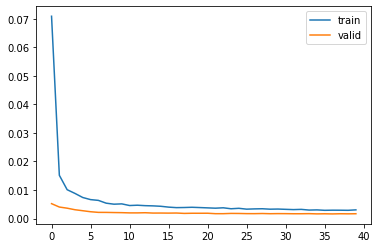

In [ ]:
# Capturing learning history per epoch
hist  = pd.DataFrame(his_mod2.history)
hist['epoch'] = his_mod2.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


Plotting confusion matrix

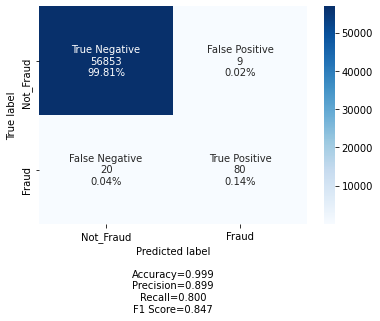

In [ ]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred1 = Model2.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm2,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

**Conclusion:**

As you can see here the Recall of the model is not improved and it is worse than the Previous ANN model as well as the RandomForest but the precision is changed.

Let's try weighted loss for imbalance dataset

### Weighted loss to account for large class imbalance in train dataset
- we will adjust the class imbalance by giving additional weight to the loss associated to errors made on fraudulent transaction detection.

We will use our first ANN model and apply weighted loss


 Let's review the process:

In [20]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

NameError: name 'y_train' is not defined

- The class 'Fraudulent' (y=1) is assigned a weight of 290 vs 0.5 for the class 'not fraudulent' due to the very low prevalence we detected during data exploration. This allows the model to give more importance to the errors made on fraudulent cases during training.

Training the model

In [ ]:
model.fit(X_train,y_train,batch_size=15,epochs=5, class_weight=class_weights, shuffle=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
15190/15190 [==============================] - 44s 3ms/step - loss: 0.4515 - accuracy: 0.9704
Epoch 2/5
15190/15190 [==============================] - 43s 3ms/step - loss: 0.2337 - accuracy: 0.9685
Epoch 3/5
15190/15190 [==============================] - 43s 3ms/step - loss: 0.3776 - accuracy: 0.9774
Epoch 4/5
15190/15190 [==============================] - 43s 3ms/step - loss: 0.3943 - accuracy: 0.9640
Epoch 5/5
15190/15190 [==============================] - 43s 3ms/step - loss: 0.4253 - accuracy: 0.9686


In [ ]:
score_weighted = model.evaluate(X_test, y_test)

1781/1781 [==============================] - 3s 2ms/step - loss: 0.0402 - accuracy: 0.9854


Plotting confusion matrix

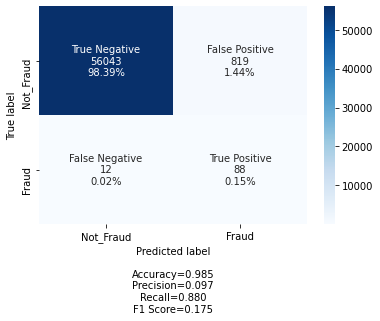

In [ ]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred1 = model.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm2,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')


 **Conclusion:**



 As you can see here the Recall is increased but the precision is very bad.  There is still  lot of scope of  improvements  as follows:

1) Threshold can be tuned to get the optimal value

2) Resampling techniques can be applied to balanced the data and then train the model

3) Hyperparameter tuning can be applied to tune the different Hyperparameters


We can select the Model-1 as our final model based on the above analysis